In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:/Data Science/Projet Kaggle/Projet NYC Taxi Fare Prediction/train.csv',nrows=2_000_000, usecols=[1,2,3,4,5,6,7])

In [3]:
df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [4]:
# Remove observations with missing values
# Since there are only a few of these, i'm not concerned with imputation
df.dropna(how='any', axis='rows', inplace=True)

# Removing observations with erroneous values
mask = df['pickup_longitude'].between(-75, -73)
mask &= df['dropoff_longitude'].between(-75, -73)
mask &= df['pickup_latitude'].between(40, 42)
mask &= df['dropoff_latitude'].between(40, 42)
mask &= df['passenger_count'].between(0, 8)
mask &= df['fare_amount'].between(0, 250)

df = df[mask]

In [5]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    
    return distance

In [6]:
def transform(data):
    # Extract date attributes and then drop the pickup_datetime column
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day'] = data['pickup_datetime'].dt.day
    data['month'] = data['pickup_datetime'].dt.month
    data['year'] = data['pickup_datetime'].dt.year
    data = data.drop('pickup_datetime', axis=1)

    # Distances to nearby airports, and city center
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    nyc = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    data['distance_to_center'] = dist(nyc[1], nyc[0],
                                      data['pickup_latitude'], data['pickup_longitude'])
    data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['long_dist'] = data['pickup_longitude'] - data['dropoff_longitude']
    data['lat_dist'] = data['pickup_latitude'] - data['dropoff_latitude']
    
    data['dist'] = dist(data['pickup_latitude'], data['pickup_longitude'],
                        data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data

In [7]:
df = transform(df)

In [9]:
import xgboost as xgb


H:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
from bayes_opt import BayesianOptimization

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('fare_amount', axis=1),
                                                    df['fare_amount'], test_size=0.25)
del(df)
dtrain = xgb.DMatrix(X_train, label=y_train)
del(X_train)
dtest = xgb.DMatrix(X_test)
del(X_test)

In [16]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [17]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

Initialization
----------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth | 
    1 | 03m05s |   -3.69920 |             0.7567 |    0.3025 |      6.6192 | 
    2 | 03m00s |   -3.69920 |             0.7536 |    0.6181 |      6.7415 | 
    3 | 02m00s |   -3.77483 |             0.5342 |    0.2390 |      5.0415 | 
Bayesian Optimization
----------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth | 
    4 | 04m09s |   -3.64777 |             0.9000 |    0.0000 |      7.0000 | 
    5 | 01m52s |   -3.69414 |             0.3000 |    0.0000 |      7.0000 | 
    6 | 01m51s |   -3.97258 |             0.9000 |    0.0000 |      3.0000 | 
    7 | 02m19s |   -3.84154 |             0.9000 |    1.0000 |      4.9490 | 
    8 | 03m24s |   -3.69944 |             0.8819 |    0.9851 |      6.9912 | 


H:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.96955261e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [18]:
params = xgb_bo.res['max']['max_params']
params['max_depth'] = int(params['max_depth'])

In [19]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, dtrain, num_boost_round=250)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

3.625319652513904
2.8894289725423956


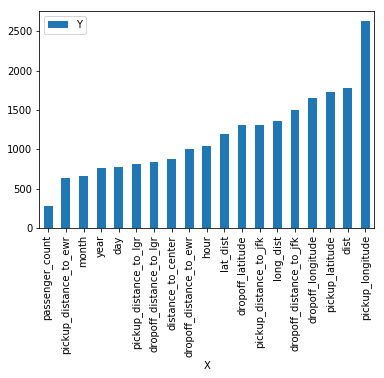

In [20]:
import matplotlib.pyplot as plt
fscores = pd.DataFrame({'X': list(model2.get_fscore().keys()), 'Y': list(model2.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

In [21]:
test = pd.read_csv('D:/Data Science/Projet Kaggle/Projet NYC Taxi Fare Prediction/test.csv').set_index('key')
test['pickup_datetime'] = test['pickup_datetime'].str.slice(0, 16)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

# Predict on holdout set
test = transform(test)
dtest = xgb.DMatrix(test)
y_pred_test = model2.predict(dtest)

In [22]:
holdout = pd.DataFrame({'key': test.index, 'fare_amount': y_pred_test})
holdout.to_csv('Taxi-Fare-Bayes-Opt-Sub.csv', index=False)